# Fake news classification meets XAI

This notebook is based on previous work during [EDA](https://www.kaggle.com/code/adrianabukaa/fake-news-eda) and it is dedicated to veryfying some hypothesis about potential one word indicators of fake/real news. We have subjectively chosen **RandomForest** model and **Shapley values** for this purposes.

Note: data preprocessing and model creation is work of @MateuszBiesiadowski

### 1. Imports

In [1]:
import os
import string
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier

import shap

import nltk

### 2. Data loading and preprocessing
Please note that test set is not explicitly stated, so we randomly choose our own and utilize it through further work.

In a nutshell, we decided to:
* remove all non alphabetical characters and urls,
* remove all english stopwords,
* utilize stemming.

In [2]:
data = pd.read_csv('../input/fake-news-classification/WELFake_Dataset.csv', 
                   index_col=0)
data = data.dropna()
y, X = data.loc[:, 'label'], data.loc[:, data.columns != 'label']

In [3]:
X_clean = pd.DataFrame({"title_text": X['title'] + " " + X['text']})

In [4]:
stopwords = set(nltk.corpus.stopwords.words('english'))
porter_steemer = nltk.stem.PorterStemmer()

In [5]:
def remove_urls(text):
    URL_REGEX = r"[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"
    return re.sub(URL_REGEX, '', text)

def remove_non_alphabetical_characters(text):
    return re.sub('[^a-zA-Z]', ' ', text)

def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word not in stopwords])
    
def stem_words(text):
    words = text.split()
    return ' '.join([porter_steemer.stem(word) for word in words])

def transform_text(text):
    text = remove_urls(text)
    text = remove_non_alphabetical_characters(text)
    text = text.lower()
    text = remove_stopwords(text)
    text = stem_words(text)
    
    return text

In [6]:
X_clean['title_text'] = X_clean['title_text'].apply(transform_text)

### 3. Model creation

In [7]:
class SimpleModelEval:
    def __init__(self, X, y, model, test_size=0.33, random_state=256):
        self.X = X
        self.y = y
        self.model = model
        self.test_size = test_size
        self.random_state = random_state
        self.results = dict()
        self.eval_data = (None, None)
    
    def train_eval(self):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
            self.X, self.y, test_size=0.33, random_state=256, stratify=self.y)
        self.eval_data = (X_test, y_test)
        
        self._train_eval_model(self.model, X_train, X_test, y_train, y_test)
    
    def _train_eval_model(self, model, X_train, X_test, y_train, y_test):
        model_name = model.__class__.__name__
        # Training model using training dataset
        model.fit(X_train, y_train)
        # Predicting the y variable for the testing dataset
        y_pred = model.predict(X_test)

        # Calculating accuracy score using predicted results and actual results
        acc = accuracy_score(y_test, y_pred)
        print(f"{model_name} fake news detection with {100 * round(acc, 4)}% accuracy")

        # Calculating False Positive Rate
        cf_matrix = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cf_matrix.ravel()
        fpr = fp / (fp + tn)
        
        # Calculating F1-score
        f1 = f1_score(y_test, y_pred)
        
        # Saving results
        self.results[model_name] = {
            "acc": acc, "fpr": fpr, "f1": f1
        }
        
        # The code below presents a confusion matrix
        cf_matrix = confusion_matrix(y_test, y_pred)
        ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

        ax.set_title(f'Confusion Matrix {model_name}\n');
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ');

        ax.xaxis.set_ticklabels(['False','True'])
        ax.yaxis.set_ticklabels(['False','True'])

        plt.show()
        
    def get_results(self):
        return pd.DataFrame.from_dict(self.results, orient='index')
    
    def get_model(self):
        return self.model
    
    def get_eval_data(self):
        return self.eval_data

In [8]:
def train_model(max_features=1000, random_state=256):
    cv = CountVectorizer(max_features=max_features)
    X_bow = cv.fit_transform(
        X_clean.title_text[~X_clean.title_text.isna()]
    ).toarray()
    y_tt = y[~X_clean.title_text.isna()]
    
    model = RandomForestClassifier(random_state=random_state, n_estimators=200)
    sme = SimpleModelEval(X_bow, y_tt, model, random_state=random_state)
    sme.train_eval()
    
    return sme.get_model(), sme.get_results(), sme.get_eval_data()

RandomForestClassifier fake news detection with 95.32000000000001% accuracy


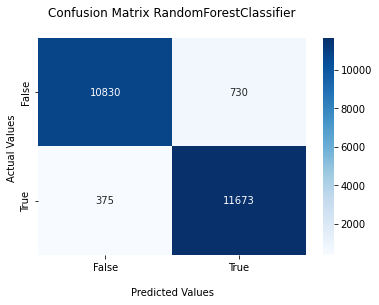

In [9]:
model, results, (X_test, y_test) = train_model()

In [10]:
results

,acc,fpr,f1
RandomForestClassifier,0.953194,0.063149,0.954808


### 4. Explain some misclassified examples

Since calculating Shapley values is computationally exhaustive, we have chosen 100 examples of correctly classified fake news from test data set, and created explanations solely based on them.

In [11]:
y_pred = model.predict(X_test)

In [107]:
fakes = np.random.choice(np.where((y_pred == 0) & (y_test == 0))[0], 100)

In [108]:
explainer = shap.Explainer(
    lambda x: model.predict_proba(x)[:, 1],
    X_test[fakes, :],
    feature_names=cv.get_feature_names_out(),
)
shap_values = explainer(X_test[fakes, :], max_evals=1989)

Permutation explainer: 101it [12:09,  7.37s/it]                         


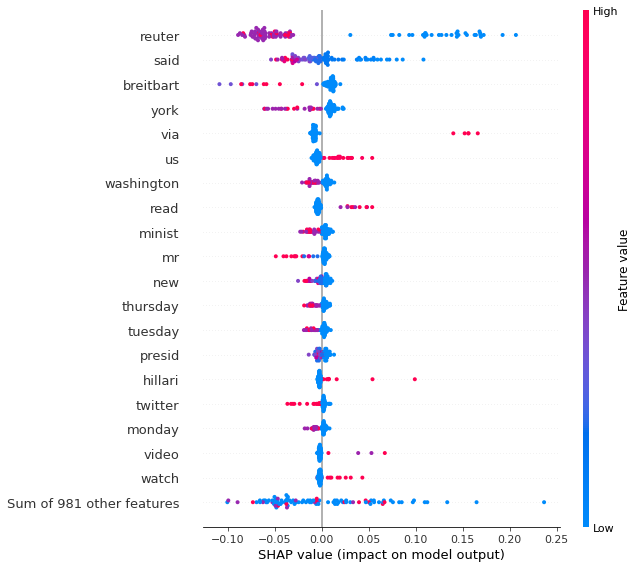

In [110]:
shap.plots.beeswarm(shap_values, max_display=20)

Comments and spot-on observations:
* as concluded during EDA, many occurences of "video" are indicators of news' authenticity,
* similarily, "Breitbart" is more common for fake news as well as "Reuter" is obviously common for real news,
* "said" is a very interesting example; maybe fake news are avoiding giving specifics, so it is harder to verify informations?
* for some reason "via" makes news more trustworthy, but it could be a bias coming from small sample (only 100 examples).

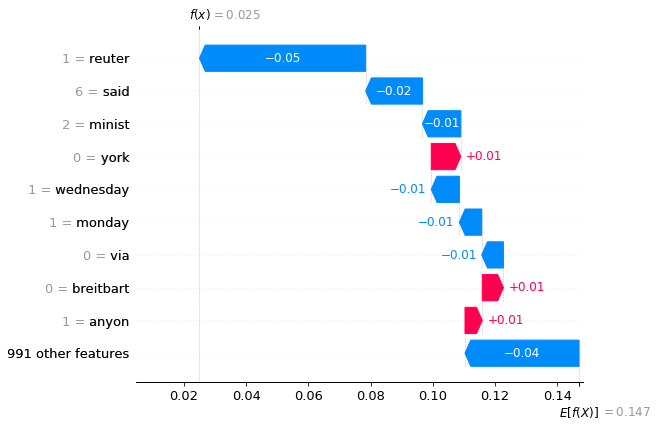

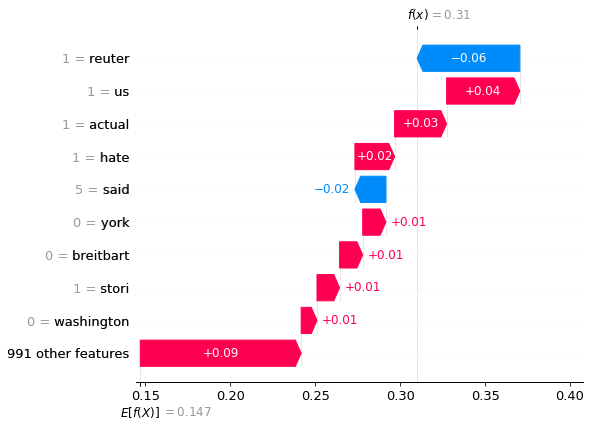

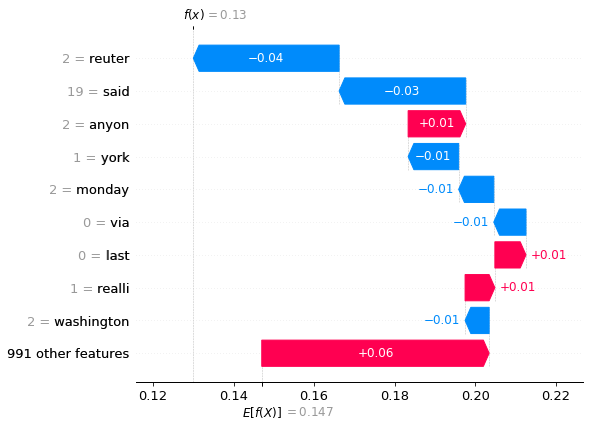

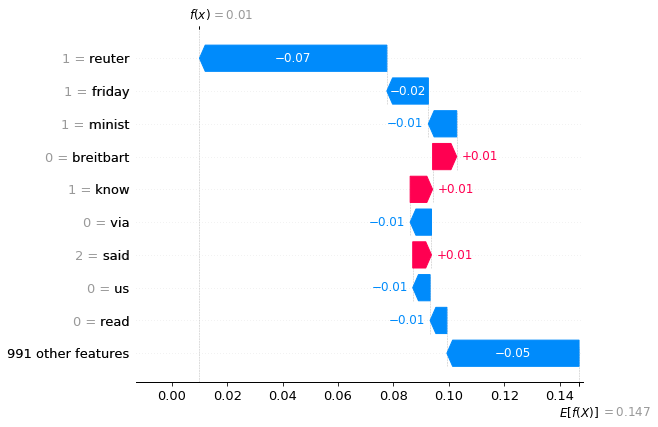

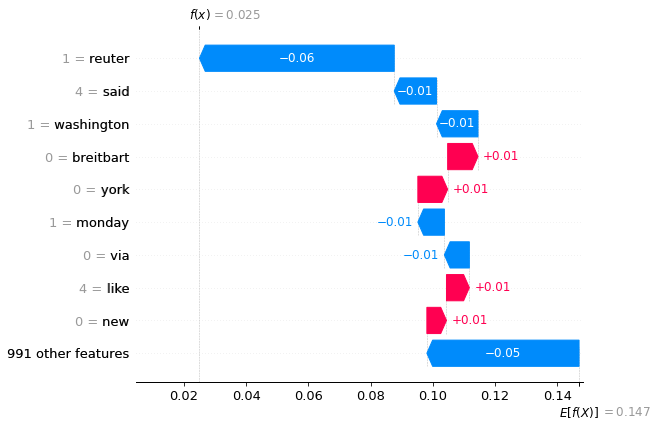

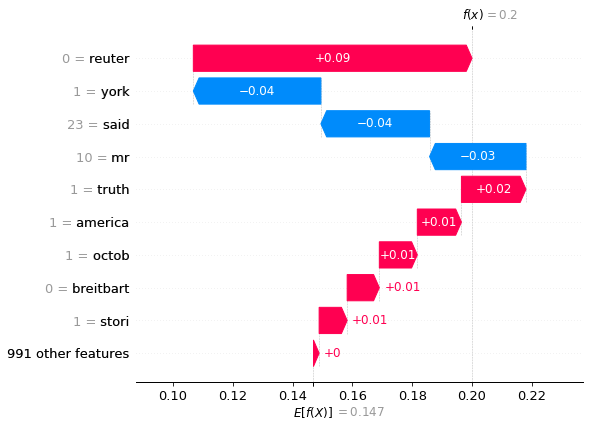

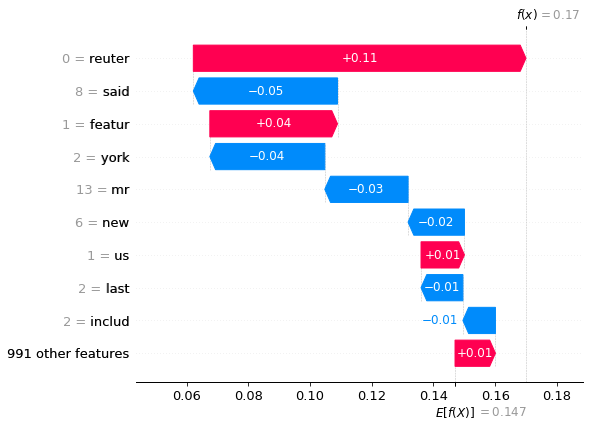

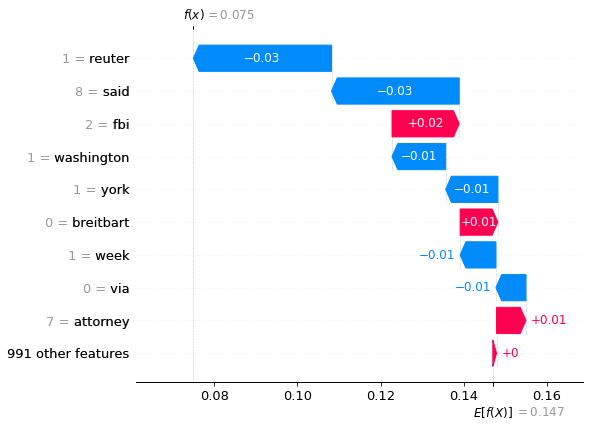

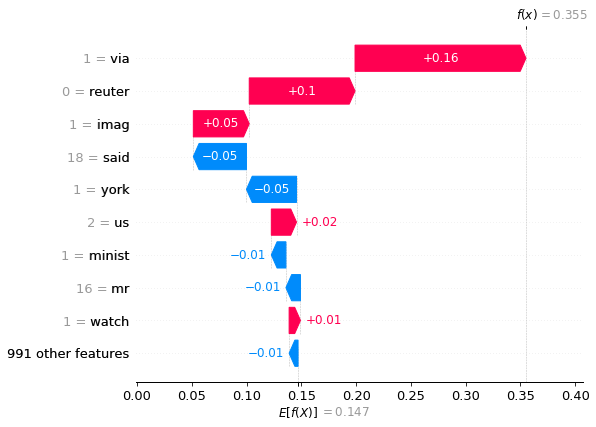

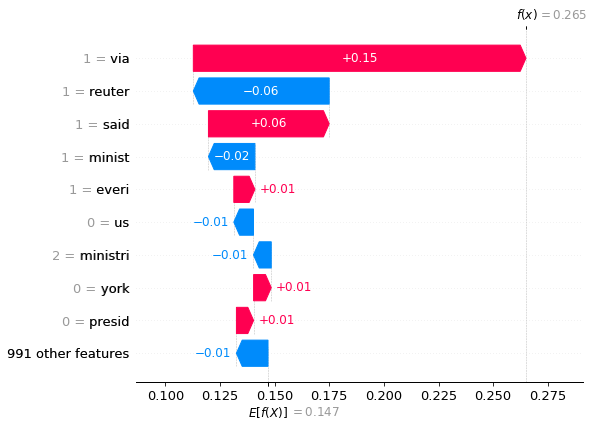

In [111]:
for i in range(10):
    shap.plots.waterfall(shap_values[i])